<a href="https://colab.research.google.com/github/wajidminhas/AI-Agents/blob/main/multiTool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [ ]:
from google.colab import userdata
userdata.get("GEMINI_API_KEY")
gemini_ap_key = userdata.get("GEMINI_API_KEY")

In [ ]:
# from langchain_google_genai import ChatGoogleGenerativeAI


# create function for location
# def locate(location_name)->str:
#   """
#   keyword arugments:
#   location_name: str

#   return: str
#   """
#   return f"I am in {location_name}"

# def addition(num1, num2):
#   """
#   keyword arugments:
#   num1: int
#   num2: int

#   return: int
#   """
#   return num1 + num2

#   tools = [locate, addition]
#   llm : ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=gemini_ap_key)

#   llm_tool = llm.bind_tools(tools)


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import StructuredTool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# create function for location
def locate(location_name : str)->str:
  """
  keyword arugments:
  location_name: str

  return: str
  """
  return  {"Location" : location_name}

tools = [StructuredTool.from_function(func=add),
    StructuredTool.from_function(func=multiply),
    StructuredTool.from_function(func=divide),
    StructuredTool.from_function(func=locate)]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = gemini_ap_key)
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import MessagesState

# create a Node
system_message = SystemMessage(content="You are a helpful assistant for arithmatic operation and regarding Geo Location")



def assistant(state : MessagesState)->MessagesState:
  return {"messages" : [llm_with_tools.invoke([system_message] + state["messages"])]}
# Graph
builder: StateGraph = StateGraph(MessagesState)


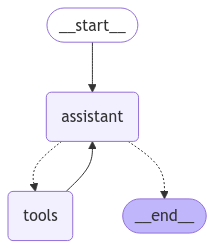

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph



# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))




In [ ]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (04deb1f0-915c-4a51-8b83-5f5554418e29)
 Call ID: 04deb1f0-915c-4a51-8b83-5f5554418e29
  Args:
    a: 3.0
    b: 4.0
  multiply (7299bd28-8676-4b83-8c06-d8c21efcf288)
 Call ID: 7299bd28-8676-4b83-8c06-d8c21efcf288
  Args:
    a: 7.0
    b: 2.0
  divide (ab2c74ce-86a9-4126-8ad8-92941afff538)
 Call ID: ab2c74ce-86a9-4126-8ad8-92941afff538
  Args:
    a: 14.0
    b: 5.0
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
================================= Tool Message =================================
Name: divide

2.8
================================== Ai Message ==================================

The sum of 3 

In [ ]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5, and where is islambad located?")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5, and where is islambad located?
================================== Ai Message ==================================
Tool Calls:
  add (09db899c-582c-486f-899d-40ef19a38d1c)
 Call ID: 09db899c-582c-486f-899d-40ef19a38d1c
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (ca2b8000-14b6-4d20-9909-180704563d1e)
 Call ID: ca2b8000-14b6-4d20-9909-180704563d1e
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (b2a07233-0f1e-4423-a692-5d320053b720)
 Call ID: b2a07233-0f1e-4423-a692-5d320053b720
  Args: